In [39]:
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.12.0


In [40]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Train shape: {train_images.shape}")
    print(f"Test shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels, class_names

train_images, train_labels, test_images, test_labels, class_names = load_data()

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [41]:
def preprocess_data(train_images, test_images):
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    return train_images, test_images

train_images, test_images = preprocess_data(train_images, test_images)

In [42]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [43]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr

def k_fold_cross_validation(k, train_images, train_labels, learning_rate, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    num_val_samples = len(train_images) // k
    all_scores = []
    all_loss = []
    highest_accuracy = 0
    for i in range(k):
        print('processing fold #', i)
        val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_images[:i * num_val_samples],
            train_images[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_labels[:i * num_val_samples],
            train_labels[(i + 1) * num_val_samples:]],
            axis=0)
        model = create_model()
        # use optimizer based on the input
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        model.compile(optimizer=opt,
                    loss=loss,
                    metrics=metrics)
        model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=[callback])
        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_acc)
        all_loss.append(val_loss)
    return all_scores, all_loss



def plot_k_fold_cross_validation(all_scores):
    # bar chart of accuracy
    min = np.min(all_scores)
    max = np.max(all_scores)
    delta = max - min
    plt.bar(range(len(all_scores)), all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('Folds')
    plt.ylabel('Accuracy')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_scores)))
    plt.show()
    # boxplot
    sns.boxplot(all_scores)
    plt.title('Accuracy Scores')
    plt.xlabel('10 folds')
    plt.ylabel('Accuracy')
    # no ticks
    plt.xticks([])
    plt.show()


def plot_k_fold_cross_validation_loss(all_loss):
    min = np.min(all_loss)
    max = np.max(all_loss)
    delta = max - min
    plt.bar(range(len(all_loss)), all_loss)
    plt.title('Loss Scores')
    plt.xlabel('Folds')
    plt.ylabel('Loss')
    plt.ylim(min - delta * 0.1, max + delta * 0.1)
    plt.xticks(range(len(all_loss)))
    plt.show()

In [44]:

all_scores, all_loss = k_fold_cross_validation(10, train_images, train_labels, learning_rate=0.001, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


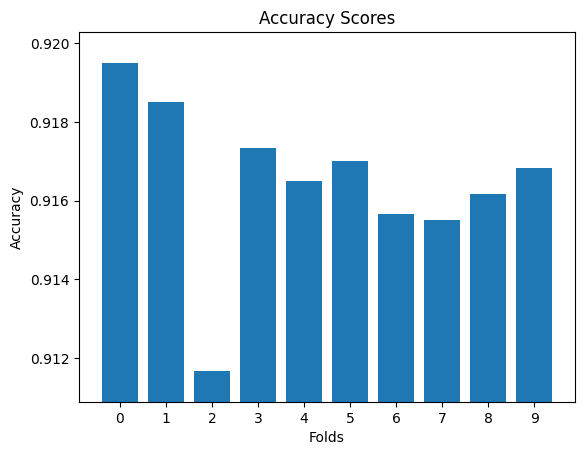

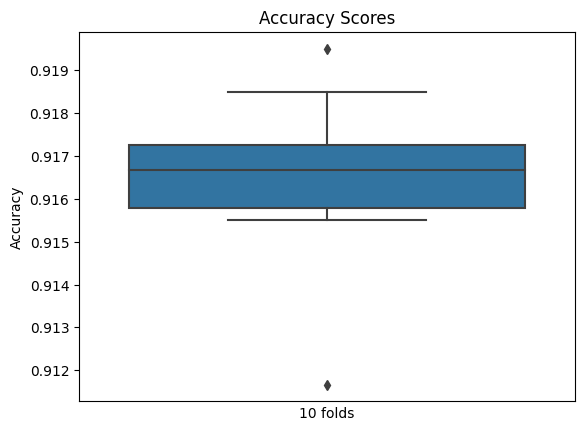

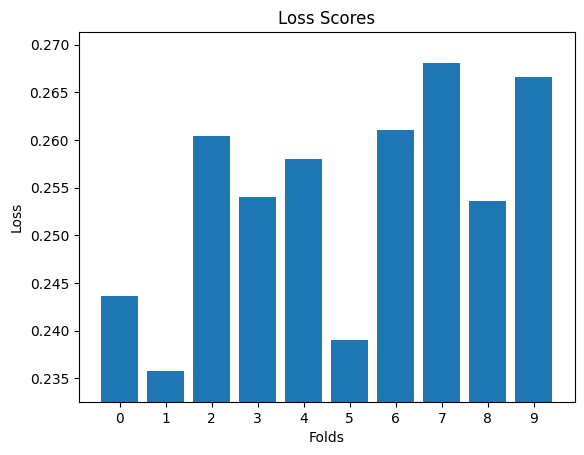

In [45]:
plot_k_fold_cross_validation(all_scores)
plot_k_fold_cross_validation_loss(all_loss)

In [46]:
#Train and Validation sets
train_images_set = train_images[:(len(train_images)-(len(train_images)//5))]
train_labels_set = train_labels[:(len(train_labels)-(len(train_labels)//5))]

validation_images_set = train_images[(len(train_images)-(len(train_images)//5)):]
validation_labels_set = train_labels[(len(train_labels)-(len(train_labels)//5)):]

In [47]:
model = create_model()

# Train the model
def train_model(train_images, train_labels , model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, validation_data=(validation_images_set, validation_labels_set), epochs=15, batch_size=64, callbacks=[callback])
    return model, history

model, history = train_model(train_images_set, train_labels_set, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Epoch 1/15
750/750 [==============================] - 13s 16ms/step - loss: 0.5835 - accuracy: 0.7904 - val_loss: 0.3830 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 12s 16ms/step - loss: 0.3627 - accuracy: 0.8691 - val_loss: 0.3491 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 12s 16ms/step - loss: 0.3090 - accuracy: 0.8875 - val_loss: 0.3346 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 12s 16ms/step - loss: 0.2770 - accuracy: 0.8983 - val_loss: 0.2854 - val_accuracy: 0.8979 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 12s 16ms/step - loss: 0.2534 - accuracy: 0.9076 - val_loss: 0.2895 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 13s 17ms/step - loss: 0.2137 - accuracy: 0.9215 - val_loss: 0.2557 - val_accuracy: 0.9056 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 

In [48]:
# plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [49]:
history.history

{'loss': [0.5834634900093079,
  0.36268213391304016,
  0.309014230966568,
  0.27697160840034485,
  0.2534411549568176,
  0.21367646753787994,
  0.19903062283992767,
  0.18812447786331177,
  0.17725549638271332,
  0.16622595489025116,
  0.1424572467803955,
  0.13491781055927277,
  0.12915179133415222,
  0.12387595325708389,
  0.11768101900815964],
 'accuracy': [0.7904166579246521,
  0.8691250085830688,
  0.8875208497047424,
  0.8982916474342346,
  0.9076041579246521,
  0.921500027179718,
  0.9265833497047424,
  0.9309583306312561,
  0.9350208044052124,
  0.9388124942779541,
  0.9480208158493042,
  0.9520208239555359,
  0.9543750286102295,
  0.9552291631698608,
  0.9581249952316284],
 'val_loss': [0.3830487132072449,
  0.3490867018699646,
  0.3345782160758972,
  0.2853732407093048,
  0.2895360589027405,
  0.2556944489479065,
  0.26222261786460876,
  0.2530795633792877,
  0.24630123376846313,
  0.24386101961135864,
  0.24436159431934357,
  0.24508097767829895,
  0.2479536086320877,
  0.26

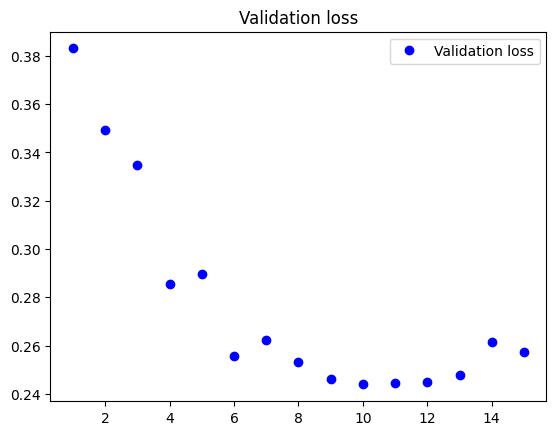

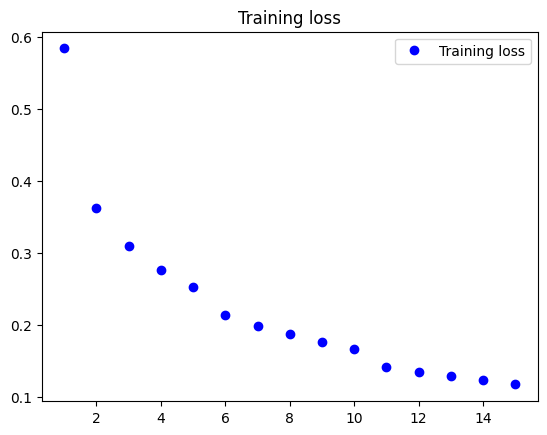

In [50]:
# plot loss and accuracy
def plot_loss_and_accuracy(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, 'bo', label='Validation loss')
    plt.title('Validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

plot_loss_and_accuracy(history)

Epoch 1/15
750/750 [==============================] - 17s 22ms/step - loss: 0.5756 - accuracy: 0.7859 - val_loss: 0.4105 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 21s 28ms/step - loss: 0.3655 - accuracy: 0.8676 - val_loss: 0.3524 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 21s 29ms/step - loss: 0.3191 - accuracy: 0.8835 - val_loss: 0.3176 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 22s 29ms/step - loss: 0.2860 - accuracy: 0.8941 - val_loss: 0.3087 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 22s 29ms/step - loss: 0.2627 - accuracy: 0.9034 - val_loss: 0.2869 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 22s 29ms/step - loss: 0.2276 - accuracy: 0.9158 - val_loss: 0.2570 - val_accuracy: 0.9053 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 

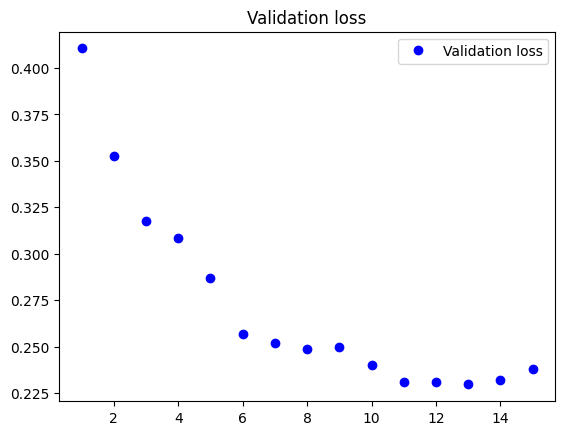

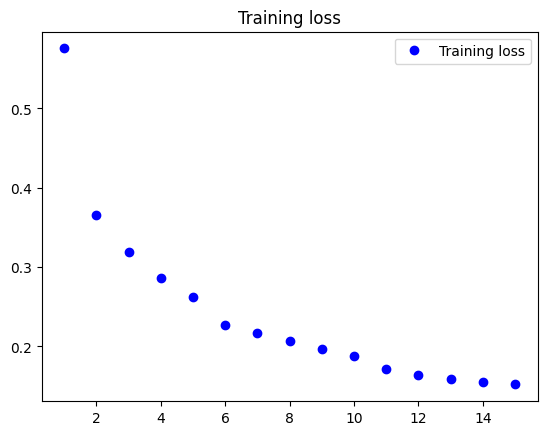

In [51]:
#Dropout inclussion after second maxpooling
#Dropout prevents overfitting by dropping a random weight (.5= 50% chance to happen)
#Dropout reduces correlation between neurons. It is added after second convolution layer before maxpolling since overfitting is most likely to happen there
def create_model_variant1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant1()

model, history = train_model(train_images_set, train_labels_set, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Dropout variant is both better than baseline on the test data and train data. A clear sign that the base model is slightly overfit.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2319 - accuracy: 0.9158 Variant1

Epoch 1/15
750/750 [==============================] - 20s 26ms/step - loss: 1.1516 - accuracy: 0.7770 - val_loss: 0.7558 - val_accuracy: 0.8245 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 19s 25ms/step - loss: 0.6184 - accuracy: 0.8557 - val_loss: 0.5919 - val_accuracy: 0.8572 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 19s 25ms/step - loss: 0.5188 - accuracy: 0.8702 - val_loss: 0.5147 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 19s 25ms/step - loss: 0.4693 - accuracy: 0.8795 - val_loss: 0.4654 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 19s 25ms/step - loss: 0.4331 - accuracy: 0.8868 - val_loss: 0.4293 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 19s 25ms/step - loss: 0.3822 - accuracy: 0.9000 - val_loss: 0.3990 - val_accuracy: 0.8912 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 

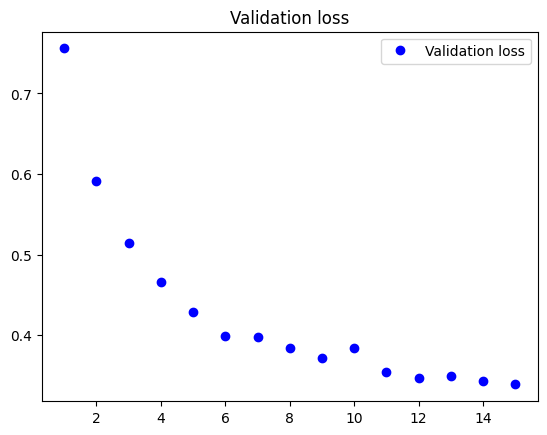

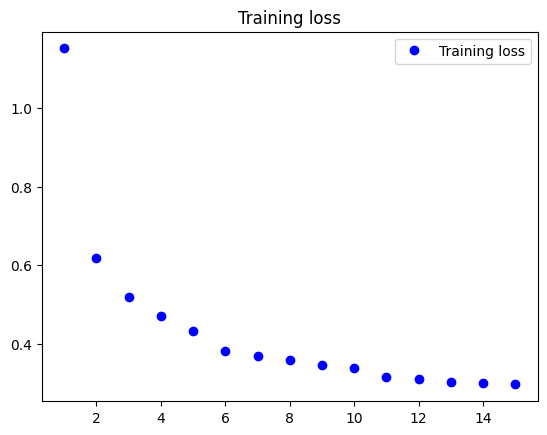

In [52]:
#L1 Regularization: Added to dense layers
#L1 prevents overfitting by making the model use more weights that are set to 0
def create_model_variant2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)),
        tf.keras.layers.Dense(10, activation='softmax' , kernel_regularizer=tf.keras.regularizers.l1(0.001))
    ])
    return model

model = create_model_variant2()

model, history = train_model(train_images_set, train_labels_set, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L1 performs better on the train data but has higher loss. This means its underfitting and will need more epochs to converge.
# In the test data it performs a bit worse than baseline.
# Different value for the strength could improve the results. In short it underfits compared to the baseline. Can't coverge fast enough in 15 epochs.
#Conclussion: loloss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.3358 - accuracy: 0.9046 Variant2

Epoch 1/15
750/750 [==============================] - 23s 29ms/step - loss: 0.4524 - accuracy: 0.8356 - val_loss: 0.3634 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 21s 28ms/step - loss: 0.3056 - accuracy: 0.8886 - val_loss: 0.3196 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 21s 28ms/step - loss: 0.2585 - accuracy: 0.9052 - val_loss: 0.2898 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 21s 28ms/step - loss: 0.2279 - accuracy: 0.9175 - val_loss: 0.2726 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 21s 28ms/step - loss: 0.2041 - accuracy: 0.9244 - val_loss: 0.2711 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 21s 28ms/step - loss: 0.1513 - accuracy: 0.9437 - val_loss: 0.2518 - val_accuracy: 0.9144 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 

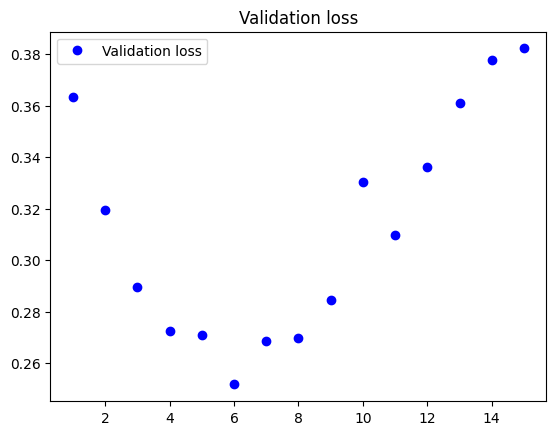

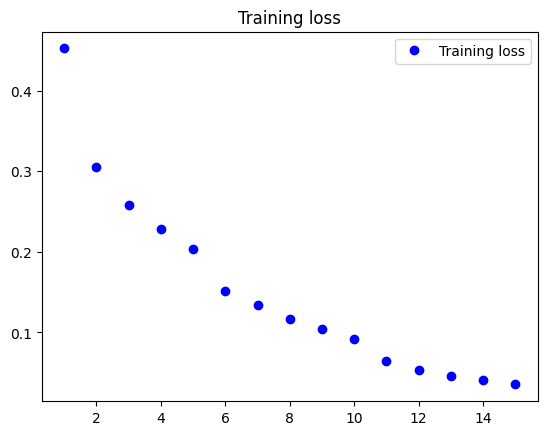

In [53]:
#Batch normalization: After first Conv2D layer 
#Stabilize learning process. Normalizes values to 0 or to 1 depending on whichever they are closer to using mean and std, solves internal covariate shift.
def create_model_variant3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model_variant3()

model, history = train_model(train_images_set, train_labels_set, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Batch normalization trains excelently BUT will need more epochs to improve validation accuracy. Seems to overfit.
#This variant could also largely improve by adding a dropping layer and regulizers to reduce overfitting (but we can only have 1 change per variant).
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.4109 - accuracy: 0.9140 Variant3

Epoch 1/15
750/750 [==============================] - 13s 17ms/step - loss: 0.6638 - accuracy: 0.7792 - val_loss: 0.4997 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 13s 17ms/step - loss: 0.4340 - accuracy: 0.8640 - val_loss: 0.4238 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 13s 17ms/step - loss: 0.3802 - accuracy: 0.8806 - val_loss: 0.3882 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 12s 17ms/step - loss: 0.3422 - accuracy: 0.8931 - val_loss: 0.3501 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 13s 17ms/step - loss: 0.3170 - accuracy: 0.9004 - val_loss: 0.3331 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 13s 17ms/step - loss: 0.2797 - accuracy: 0.9136 - val_loss: 0.3101 - val_accuracy: 0.9022 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 

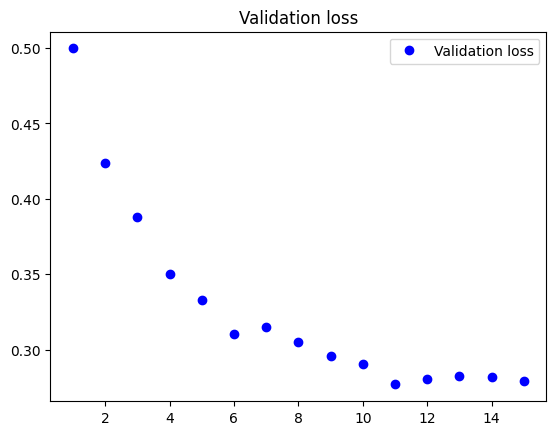

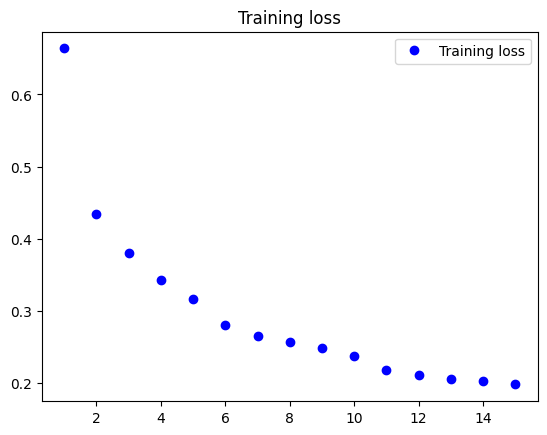

In [54]:
#L2 Regularization: Adding to dense layers
#L2 prevents overfitting by slowly melting large weight values, encourages model to use lower weights
def create_model_variant4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    return model

model = create_model_variant4()

model, history = train_model(train_images_set, train_labels_set, model)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L2 variant is a lot better than baseline on the train data but the accuracy seems better on the test data.
# It seems to converge faster however also appears to overfit since loss is higher on the test data.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2698 - accuracy: 0.9173 Variant4

In [55]:
#Two Best performing CNNs

model1Drop = create_model_variant1()
model2Batch = create_model_variant3()

model1Drop, historyDrop = train_model(train_images, train_labels, model1Drop)

model2Batch, historyBatch = train_model(train_images, train_labels, model2Batch)


Epoch 1/15
938/938 [==============================] - 21s 21ms/step - loss: 0.5571 - accuracy: 0.7974 - val_loss: 0.4229 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 20s 21ms/step - loss: 0.3581 - accuracy: 0.8713 - val_loss: 0.3249 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 20s 21ms/step - loss: 0.3151 - accuracy: 0.8863 - val_loss: 0.2985 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 21s 22ms/step - loss: 0.2850 - accuracy: 0.8960 - val_loss: 0.2803 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 20s 22ms/step - loss: 0.2642 - accuracy: 0.9029 - val_loss: 0.2396 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 21s 22ms/step - loss: 0.2281 - accuracy: 0.9160 - val_loss: 0.2275 - val_accuracy: 0.9222 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 

In [56]:
# Evaluate the model1
test_loss, test_acc = model1Drop.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


# Evaluate the model2
test_loss, test_acc = model2Batch.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

313/313 [==============================] - 1s 3ms/step - loss: 0.2306 - accuracy: 0.9172
Test accuracy: 0.9172000288963318
Test loss: 0.23059652745723724
313/313 [==============================] - 1s 4ms/step - loss: 0.4181 - accuracy: 0.9128
Test accuracy: 0.9128000140190125
Test loss: 0.4180555045604706
